In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import json
from src.data import dataloader
from src.models.utils import load_dataset
import tensorflow as tf

# plot options
plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=9) #fontsize of the x tick labels
plt.rc('ytick', labelsize=9) #fontsize of the y tick labels
plt.rc('legend', fontsize=9) #fontsize of the legend

# open config file
f = open("..//config//config.json",)
config = json.load(f)

### Temporal filters

In [2]:
# info object
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
info = mne.create_info(channels, config["dataset"]["sampling_frequency"], ch_types='eeg').set_montage('biosemi64')

In [3]:
# load model
model_path = "..//models//" + config["train"]["experiment_desc"] + "-best.h5"
model = tf.keras.models.load_model(model_path)

In [4]:
# load test data
config["dataset"]["save_path"] = "..//data//"
_, _, _, _, X_test, y_test = load_dataset(config)

# get test set labels
labels = np.argmax(y_test, axis=1)

In [5]:
# path temporal filters weights
path = "..//" + config["train"]["weights_save_path"] + config["train"]["experiment_desc"] + "_output_tempfilt_"

In [6]:
# get output of temporal convolution layer
mod = tf.keras.Model(model.layers[0].input, model.layers[1].output) # reconstruct model to give output at first conv layer

# initialize arrays
output_lowclass  = np.empty((0,14,384,config["train"]["temporal_filters"]))
output_highclass = np.empty((0,14,384,config["train"]["temporal_filters"]))

for index, window in enumerate(X_test): # predict each segmented window in the test set
    out = mod.predict(np.expand_dims(window, axis = 0))[0] # shape = (14, time samples, F1)
    label = labels[index] # window-associated label
    
    if label == 0:
        output_lowclass = np.vstack((output_lowclass, np.expand_dims(out,0)))  

    elif label == 1:
        output_highclass = np.vstack((output_highclass, np.expand_dims(out,0))) 
        
# save
np.save(path + 'lowclass.npy', output_lowclass)
np.save(path + 'highclass.npy', output_highclass)


In [7]:
# load the saved first layer outputs divided in low and high class 
out_highclass = np.load(path + 'highclass.npy')
out_lowclass = np.load(path + 'lowclass.npy')

In [8]:
out_highclass.shape

(1178, 14, 384, 8)

In [9]:
out_lowclass.shape

(1152, 14, 384, 8)

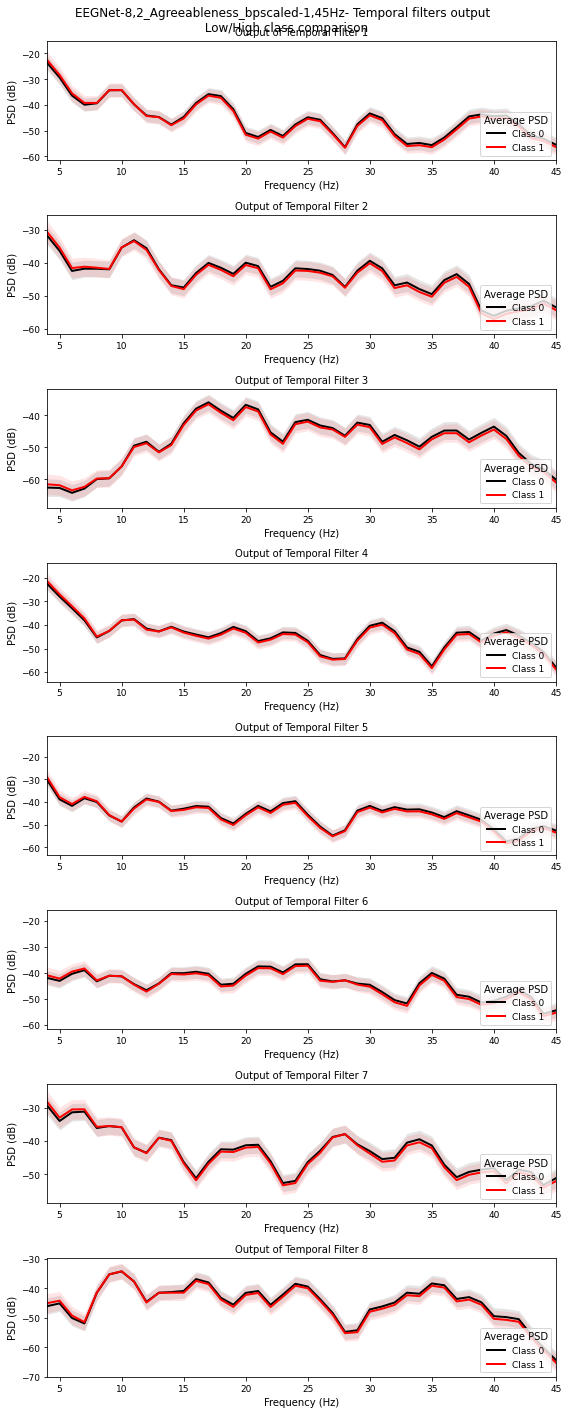

In [10]:
# plot
f, ax = plt.subplots(nrows=config["train"]["temporal_filters"], ncols=1, figsize=(8,20))
plt.suptitle(config["train"]["experiment_desc"]  + '- Temporal filters output \n Low/High class comparison')

# loop through filters
for temp in range(out_highclass.shape[3]):
    
    # make mne epochs object
    hepo = mne.EpochsArray(out_highclass[:,:,:,temp], info, verbose = 0)
    lepo = mne.EpochsArray(out_lowclass[:,:,:,temp], info, verbose = 0)
    
    # psd
    h_psd, h_freqs = mne.time_frequency.psd_welch(hepo, average='mean', fmin=.1, fmax=45, n_fft=128, n_overlap=64, n_jobs=1, verbose=0) 
    h_psd = 10 * np.log10(h_psd)  # convert to dB
    h_psd_mean = h_psd.mean(0).mean(0)
    h_psd_std = h_psd.mean(0).std(0)

    l_psd, l_freqs = mne.time_frequency.psd_welch(lepo, average='mean', fmin=.1, fmax=45, n_fft=128, n_overlap=64, n_jobs=1, verbose=0) 
    l_psd = 10 * np.log10(l_psd)  # convert to dB
    l_psd_mean = l_psd.mean(0).mean(0)
    l_psd_std = l_psd.mean(0).std(0)
    
    ax[temp].plot(l_freqs, l_psd_mean, linewidth=2, color='k')
    ax[temp].fill_between(l_freqs, l_psd_mean + l_psd_std, l_psd_mean - l_psd_std, alpha=.1, linewidth=0, color='k')
    ax[temp].plot(h_freqs, h_psd_mean, linewidth=2, color='r')
    ax[temp].fill_between(h_freqs, h_psd_mean + h_psd_std, h_psd_mean - h_psd_std, alpha=.1, linewidth=0, color='r')
    ax[temp].set(title='Output of Temporal Filter ' + str(temp+1), xlabel='Frequency (Hz)', ylabel='PSD (dB)', xlim=(4,45))
    ax[temp].legend(['Class 0', 'Class 1'], title='Average PSD', loc="lower right")
    plt.tight_layout()

### Spatial filters

In [22]:
path = "..//" + config["train"]["weights_save_path"] + config["train"]["experiment_desc"] + "_output_spatfilt_"

In [23]:
# get output of depthwise convolution layer
mod = tf.keras.Model(model.layers[0].input, model.layers[3].output) # reconstruct model to give output at depthwise conv layer

# initialize arrays
output_lowclass  = np.empty((0,1,384,config["train"]["temporal_filters"]*config["train"]["spatial_filters_depth"]))
output_highclass = np.empty((0,1,384,config["train"]["temporal_filters"]*config["train"]["spatial_filters_depth"]))

for index, window in enumerate(X_test): # predict each segmented window in the test set
    out = mod.predict(np.expand_dims(window, axis = 0))[0] # shape = (1, time samples, F1*D)
    label = labels[index] # window-associated label
    
    if label == 0:
        output_lowclass = np.vstack((output_lowclass, np.expand_dims(out,0)))  

    elif label == 1:
        output_highclass = np.vstack((output_highclass, np.expand_dims(out,0))) 
        
# save
np.save(path + 'lowclass.npy', output_lowclass)
np.save(path + 'highclass.npy', output_highclass)

In [24]:
# load the saved first layer outputs divided in low and high class 
out_highclass = np.load(path + 'highclass.npy')
out_lowclass = np.load(path + 'lowclass.npy')

In [25]:
out_highclass.shape

(1178, 1, 384, 16)

In [26]:
out_lowclass.shape

(1152, 1, 384, 16)

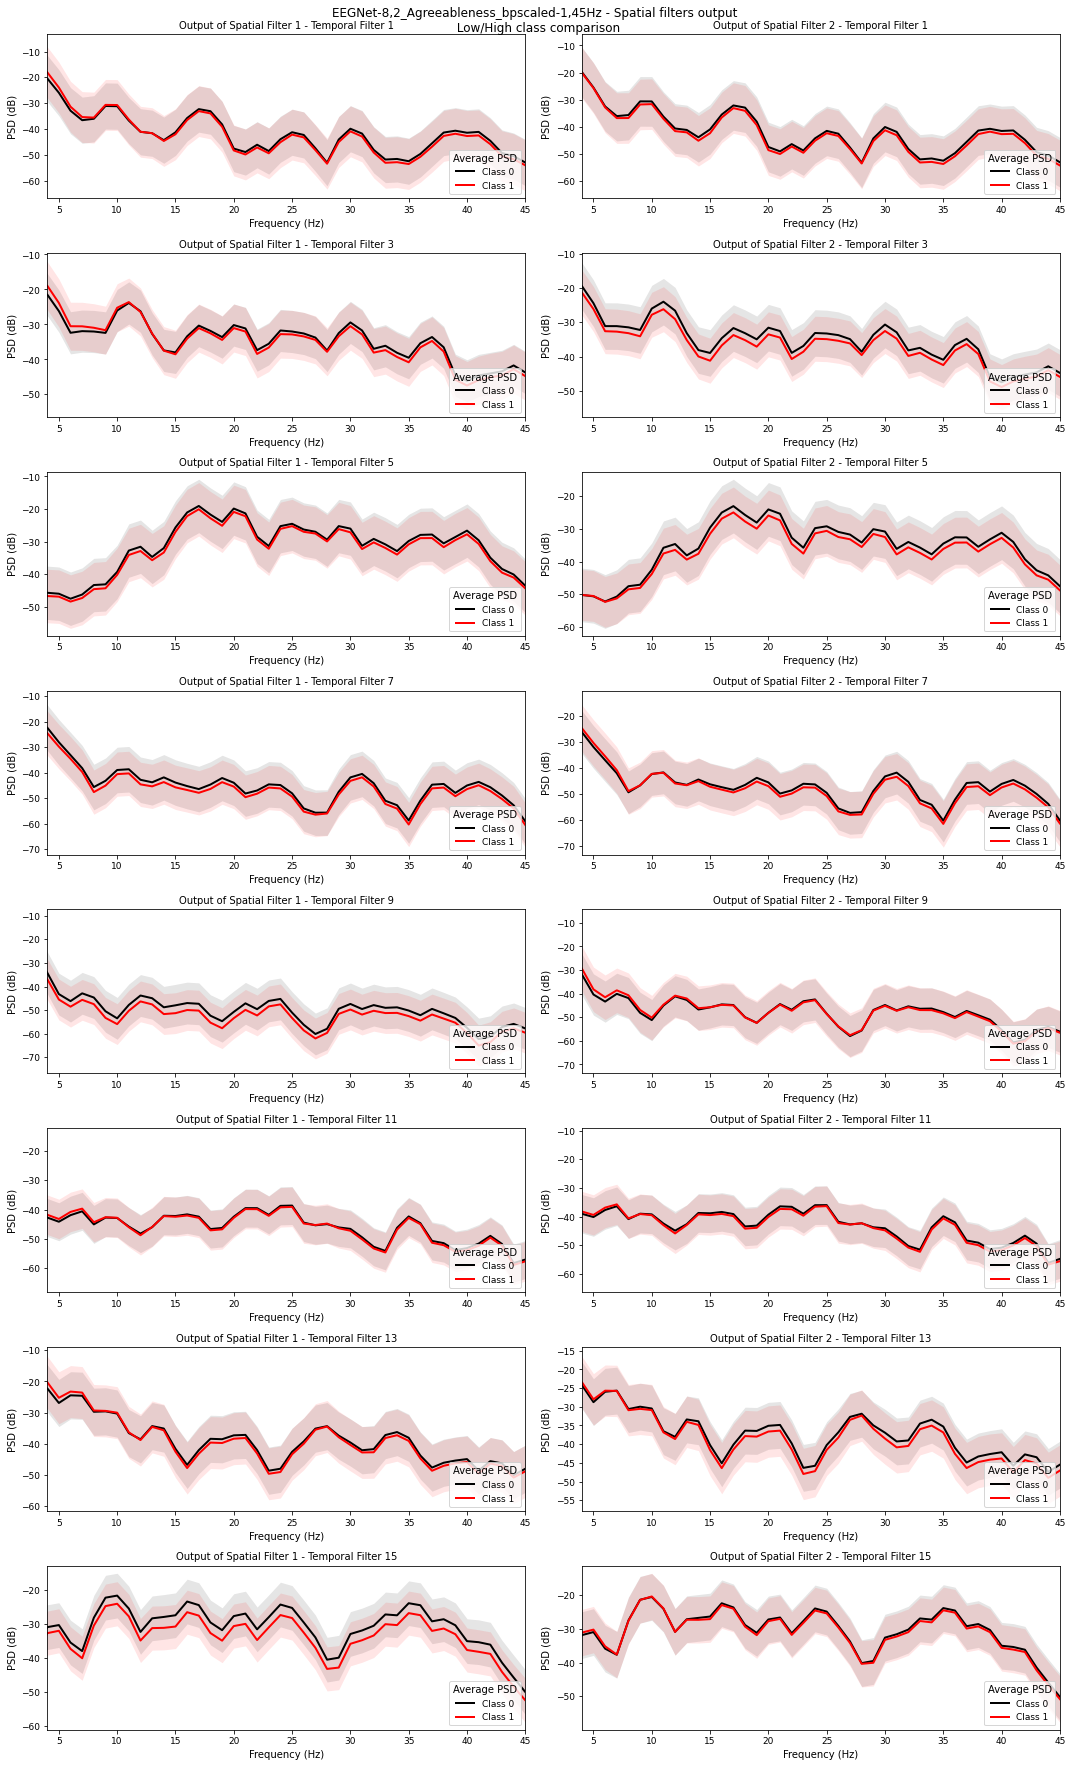

In [37]:
# info object
channels = ['']
info = mne.create_info(channels, config["dataset"]["sampling_frequency"], ch_types='eeg')

# plot
f, ax = plt.subplots(nrows=config["train"]["temporal_filters"], ncols=config["train"]["spatial_filters_depth"], figsize=(15,25))
plt.suptitle(config["train"]["experiment_desc"] + ' - Spatial filters output \n Low/High class comparison')

# loop through filters
for idx_temp, temp in enumerate(range(0, config["train"]["temporal_filters"]*config["train"]["spatial_filters_depth"], 2)):

        # make mne epochs object
        hepo_s1 = mne.EpochsArray(out_highclass[:,:,:,temp], info, verbose = 0)
        lepo_s1 = mne.EpochsArray(out_lowclass[:,:,:,temp], info, verbose = 0)
        
        hepo_s2 = mne.EpochsArray(out_highclass[:,:,:,temp+1], info, verbose = 0)
        lepo_s2 = mne.EpochsArray(out_lowclass[:,:,:,temp+1], info, verbose = 0)

        # psd
        hs1_psd, hs1_freqs = mne.time_frequency.psd_welch(hepo_s1, average='mean', fmin=.1, fmax=45, n_fft=128, n_overlap=64, n_jobs=1, verbose=0) 
        hs1_psd = 10 * np.log10(hs1_psd)  # convert to dB
        hs1_psd_mean = hs1_psd.mean(0).mean(0)
        hs1_psd_std = hs1_psd_mean.std(0)

        ls1_psd, ls1_freqs = mne.time_frequency.psd_welch(lepo_s1, average='mean', fmin=.1, fmax=45, n_fft=128, n_overlap=64, n_jobs=1, verbose=0) 
        ls1_psd = 10 * np.log10(ls1_psd)  # convert to dB
        ls1_psd_mean = ls1_psd.mean(0).mean(0)
        ls1_psd_std = ls1_psd_mean.std(0)

        hs2_psd, hs2_freqs = mne.time_frequency.psd_welch(hepo_s2, average='mean', fmin=.1, fmax=45, n_fft=128, n_overlap=64, n_jobs=1, verbose=0) 
        hs2_psd = 10 * np.log10(hs2_psd)  # convert to dB
        hs2_psd_mean = hs2_psd.mean(0).mean(0)
        hs2_psd_std = hs2_psd_mean.std(0)

        ls2_psd, ls2_freqs = mne.time_frequency.psd_welch(lepo_s2, average='mean', fmin=.1, fmax=45, n_fft=128, n_overlap=64, n_jobs=1, verbose=0) 
        ls2_psd = 10 * np.log10(ls2_psd)  # convert to dB
        ls2_psd_mean = ls2_psd.mean(0).mean(0)
        ls2_psd_std = ls2_psd_mean.std(0)

        ax[idx_temp,0].plot(ls1_freqs, ls1_psd_mean, linewidth=2, color='k')
        ax[idx_temp,0].fill_between(ls1_freqs, ls1_psd_mean + ls1_psd_std, ls1_psd_mean - ls1_psd_std, alpha=.1, linewidth=0,color='k')
        ax[idx_temp,0].plot(hs1_freqs, hs1_psd_mean, linewidth=2, color='r')
        ax[idx_temp,0].fill_between(hs1_freqs, hs1_psd_mean + hs1_psd_std, hs1_psd_mean - hs1_psd_std, alpha=.1, linewidth=0, color='r')
        ax[idx_temp,0].set(title='Output of Spatial Filter 1 - Temporal Filter ' + str(temp+1), xlabel='Frequency (Hz)', ylabel='PSD (dB)', xlim=(4,45))
        ax[idx_temp,0].legend(['Class 0', 'Class 1'], title='Average PSD', loc="lower right")

        ax[idx_temp,1].plot(ls2_freqs, ls2_psd_mean, linewidth=2, color='k')
        ax[idx_temp,1].fill_between(ls2_freqs, ls2_psd_mean + ls2_psd_std, ls2_psd_mean - ls2_psd_std, alpha=.1, linewidth=0, color='k')
        ax[idx_temp,1].plot(hs2_freqs, hs2_psd_mean, linewidth=2, color='r')
        ax[idx_temp,1].fill_between(hs2_freqs, hs2_psd_mean + hs2_psd_std, hs2_psd_mean - hs2_psd_std, alpha=.1, linewidth=0, color='r')
        ax[idx_temp,1].set(title='Output of Spatial Filter 2 - Temporal Filter ' + str(temp+1), xlabel='Frequency (Hz)', ylabel='PSD (dB)', xlim=(4,45))
        ax[idx_temp,1].legend(['Class 0', 'Class 1'], title='Average PSD', loc="lower right")

        plt.tight_layout()